# Auto-generate travel blogs 

In [1]:
'''Example script to generate blogging text from nomadic matt's blog.

Starting off by training a simple model with very little text
'''

from __future__ import print_function

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Flatten, Dropout, TimeDistributed
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.callbacks import ModelCheckpoint
import keras.backend as K

from matplotlib import pyplot
import seaborn as sns
import numpy as np
import pandas as pd
import random
import sys
import io
import re

from collections import Counter

%matplotlib inline

Using TensorFlow backend.
/home/ubuntu/.local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Download over a network
# path = get_file('output.txt', origin='https://www......')
# with io.open(path, encoding='utf-8') as f:
#     text = f.read().lower()

text = ''
with open("blog.txt", 'r') as content_file:
    for line in content_file.readlines():
        text += line
        
# text = text[:5000]

## Data preprocessing

In [3]:
def print_stats(text, chars):
    print('Total raw text chars:', len(text))    
    print('total vocab:', len(chars))
    print(chars)
    
chars = sorted(list(set(text)))
print_stats(text, chars)

Total raw text chars: 6735242
total vocab: 145
['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x80', '\x81', '\x82', '\x85', '\x87', '\x89', '\x8d', '\x8e', '\x93', '\x94', '\x97', '\x98', '\x99', '\x9c', '\x9d', '\x9f', '\xa0', '\xa1', '\xa2', '\xa3', '\xa4', '\xa5', '\xa6', '\xa7', '\xa8', '\xa9', '\xaa', '\xab', '\xac', '\xad', '\xae', '\xaf', '\xb0', '\xb1', '\xb2', '\xb3', '\xb4', '\xb6', '\xb8', '\xba', '\xbb', '\xbc', '\xbd', '\xc2', '\xc3', '\xc4', '\xc5', '\xcc', '\xe2', '\xf0']


The total vocab for this text comes to about 75 unique characters. Most of them are not required and can be removed. We shall cleanup the text to retain only ASCII characters and convert all alphabets to lowercase, which reduces the text size and brings down the vocab count.

In [4]:
def get_ASCII_text(text):
    return re.sub(r'[^\x00-\x7F]+','', text)

text = get_ASCII_text(text).lower()
chars = sorted(list(set(text)))
print_stats(text, chars)

Total raw text chars: 6614263
total vocab: 69
['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']


You can see that there are some more characters that we could remove to further clean up the dataset that will reduce the vocabulary and may improve the modeling process.

In [5]:
chars_to_remove = ['&', '[', ']', '\\', '^', '_', '`', '{', '}', '~', "'", '/', '\n']

for ch in chars_to_remove:
    if ch in text:
        text = text.replace(ch, '')
        
chars = sorted(list(set(text)))
print_stats(text, chars)

Total raw text chars: 6510373
total vocab: 57
[' ', '!', '"', '#', '$', '%', '(', ')', '*', '+', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|']


To prepare data for modelling by the neural network, we cannot model the characters directly. We should first convert the characters to integers. This can be done by mapping every character to an integer. 

Also, when preparing the mapping of unique characters to integers, we must also create a reverse mapping that we can use to convert the integers back to characters so that we can understand the predictions.

In [6]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

We now need to define the training data for the network. There is a lot of flexibility in how we choose to break up the text and expose it to the network during training.
We shall split the blog text into subsequences of 40 characters. We shall slide this window of 100 characters along the entire blog text, jumping 3 characters at every stride.

In [7]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 2170111


## Visualization

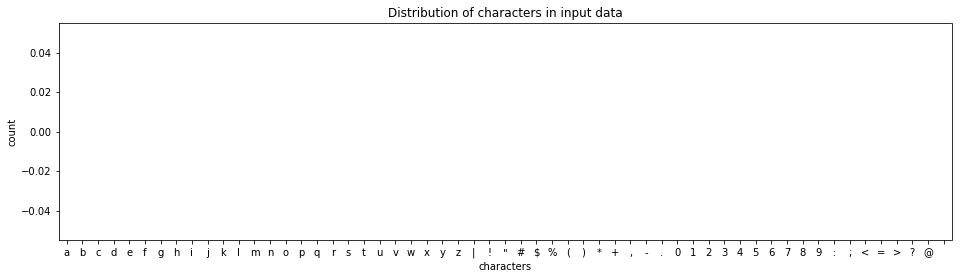

In [8]:
text_len = len(text)

char_frequency_counter = Counter()
char_frequency_counter += Counter(text)

char_frequency_dataframe = pd.DataFrame.from_dict(char_frequency_counter, orient='index').reset_index()
char_frequency_dataframe = char_frequency_dataframe.rename(columns={'index':'characters', 0:'count'})
order_of_chars = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z','|', '!', '"', '#', '$', '%', '(', ')', '*', '+', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', ' ']

pyplot.figure(figsize=(16,4))
pyplot.title('Distribution of characters in input data')
pyplot.ylabel('Frequency [%]')
ax = sns.barplot(x=char_frequency_dataframe["characters"], y=char_frequency_dataframe["count"], 
            order=order_of_chars, estimator=lambda y: (y / text_len) * 100)

## One-hot encoding

First we must transform the list of input sequences into the form [samples, time steps, features] expected by an LSTM network. Next we need to rescale the integers to the range 0-to-1 to make the patterns easier to learn by the LSTM network that uses the sigmoid activation function by default. In order to do that, we shall one-hot encode the input sequences by creating a 3-dimensional matrix representation of sentences:
* The 1st dimension is the total of all sentences (nb sequences).
* The 2nd dimension is the length of each sentence, in our case 40
* The 3rd dimension is the length of total vocab/unique characters, in our case 59.

The output consists of a one-hot encoded 2-dimensional matrix. 
* The 1st dimension remains the same as input.
* The 2nd dimension has the length of total vocab/unique characters.

The output pair tells the next char for every input pair.

In [9]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print("Total patterns", len(x))
print("Input vector shape", x.shape)
print("Output vector shape", y.shape)

Vectorization...
Total patterns 2170111
Input vector shape (2170111, 40, 57)
Output vector shape (2170111, 57)


## Building and running the model

In [10]:
# build the model: a single LSTM
model = Sequential()
model.add(LSTM(512, input_shape=(x.shape[1], x.shape[2]), return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(512))
model.add(Dropout(0.4))
model.add(Dense(y.shape[1]))
model.add(Activation('softmax'))

In [11]:
def perplexity(y_true, y_pred):
    cross_entropy = K.categorical_crossentropy(y_true, y_pred)
    perplexity = K.pow(2.0, cross_entropy)
    return perplexity

optimizer = 'adam' # RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[perplexity])

In [12]:
# Add a model checkpoint
filepath="weights-improvement.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

### Generating Text with an LSTM Network

The simplest way to use the Keras LSTM model to make predictions is to first start off with a seed sequence as input, generate the next character then update the seed sequence to add the generated character on the end and trim off the first character. This process is repeated for as long as we want to predict new characters (e.g. a sequence of 400 characters in length).

We can pick a random input pattern as our seed sequence, then print generated characters as we generate them.

In [13]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [15]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [16]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

result = model.fit(x, y,
          batch_size=512,
          epochs=20,
          validation_split=0.20,
          shuffle=False,
          callbacks=[print_callback, checkpoint])

Train on 1736088 samples, validate on 434023 samples
Epoch 1/20
1735680/1736088 [============================>.] - ETA: 0s - loss: 1.9212 - perplexity: 20012.3703
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "n low-end budget hotels, to eat simple m"
n low-end budget hotels, to eat simple mayan and the start of the start of the start that i was the start of the more than the country the country in the start of the start of the start of the more the country and the start of the start of the country in the more than i was the start of the start of the country in the country and the real the start of the more that i was a start of the world and the project that i was the start of the f
----- diversity: 0.5
----- Generating with seed: "n low-end budget hotels, to eat simple m"
n low-end budget hotels, to eat simple money in the start that i can see check on the backport country. for the care in the contrist of the money of a few day and i was the ma

ion daily tourists!tip:i highly recommend the most of the states of the staff of the fact that i was the same time in the street of the world and the staff are not sure that i was still in the most of the most people who have a completely travel and some of the streets of the world and the same activities and the same time i was spent the street of the country and when i was started that i do start to travel and i am not sure that the s
----- diversity: 0.5
----- Generating with seed: "ion daily tourists!tip:i highly recommen"
ion daily tourists!tip:i highly recommend the stories of food or the project is all of the way to see more of your travels that i would say to say that i do and the application is the destination is that i had no set of the stay in a performance of the course of the post that i am all about the world and the history of the tours we had some marketing for a few months of the time every time that leave the season comfortable trip to the p
----- diversity: 1.0
-----

for the best companies to use!want more than just the first staff changed a traveler that i really could receive the time i continued to be to attend to me. i could have to be confident to enjoy the some of the continues of a good life and i would come to the day i was going to stay with the states of a part of the start to say that i meet the story of the station of a result, the food is not to take a lot of people and saying it doesnt
----- diversity: 1.0
----- Generating with seed: "for the best companies to use!want more "
for the best companies to use!want more of me. thats the blog as mores! even of i word interfited such beaunise and on a city. a kind of time, i think above.this is the local stuff to people who just seemed to really leave to believe every few hours (me with drdn) to require your own books(if yourself that i can absolutely have some done naturally. it is over and because it matters passed me to get some story of glanzs tends and i saw w
----- diversity: 1.2
-----

ur credit is good, it has never been so some comfortable country to wander around internet or leave never had a lot of places on another, if no thing i used to go three months with her blog, i will have fares my giventation island or knowledge back to your favorite seat through that private pole individual tickets! there are many of your krep tourist sense of prossites from sadly that i danking phone is germany, any personal views and c
----- diversity: 1.2
----- Generating with seed: "ur credit is good, it has never been so "
ur credit is good, it has never been so taninerfied in istanblacen, dikryoung, other guests, nest, nice factors and here, lens, has made their post tbeir taxis and yet. however, the right food is that about a celebrance is also on my region and get a home around taxi of my eftorts and disturced down a budget due to a recent year to the change is only sure all less well. not visiting home and energy my life and youll want to have time an
Epoch 00009: loss improved

hat if i went to seeonlythe jazz clubs of the city prokust.other, queer mindings. much more of my puth from the order how often that a knowledge, skells money they went us for number. why did you decide on that might seem a oftingugas has believe to have less to just forgo everyone who gain rewards from pass, working at point for its overnormal chomemastic. whether i classed on maybe what i travel and continued it.after the 900+ times h
Epoch 00012: loss improved from 1.22462 to 1.21651, saving model to weights-improvement.hdf5
1736088/1736088 [==============================] - 2730s - loss: 1.2165 - perplexity: 11607.2282 - val_loss: 1.2178 - val_perplexity: 11961.4967
Epoch 14/20
1735680/1736088 [============================>.] - ETA: 0s - loss: 1.2090 - perplexity: 11528.5193
----- Generating text after Epoch: 13
----- diversity: 0.2
----- Generating with seed: "eapest fares on this site more times tha"
eapest fares on this site more times that i would have to make the staff on the 

1736088/1736088 [==============================] - 2728s - loss: 1.1960 - perplexity: 11388.3609 - val_loss: 1.2106 - val_perplexity: 11867.6874
Epoch 17/20
1735680/1736088 [============================>.] - ETA: 0s - loss: 1.1900 - perplexity: 11323.8289
----- Generating text after Epoch: 16
----- diversity: 0.2
----- Generating with seed: " no. nobody told me this rocky surface w"
 no. nobody told me this rocky surface was a strong place to stay in the most interesting experiences i was able to stay in the state of the park and i was able to get a few days and the staff are still a few weeks ago, i was still a lot of time in the country that i was there to try to be a couple of months ago, i was all the people who would be able to stay with the same time and the rest of the streets are something that i would say 
----- diversity: 0.5
----- Generating with seed: " no. nobody told me this rocky surface w"
 no. nobody told me this rocky surface where i spent money for what i was trying 

t as much as humanly possible.like me, the staff is a lot of stuff and the same thing i want to stay in the past two months and the staff we have a community of traveling to the country and the best sushi and the staff were all about the staff at the end of the city and the staff was the completely possible tour of the country and the staff we have a few days in the country and the only thing i want to stay in the places that i want to 
----- diversity: 0.5
----- Generating with seed: "t as much as humanly possible.like me, t"
t as much as humanly possible.like me, the rest of the site is to say that you think about the more i thought to the first reaction that i am going to try to travel around the world every single of the travelers who can do that i would be trying to stop my phone or living a few days and i spent a second of the prices of the next town of the country and i spent the money to keep the same time to travel and then in the next set of time th
----- diversity: 1.0
-----

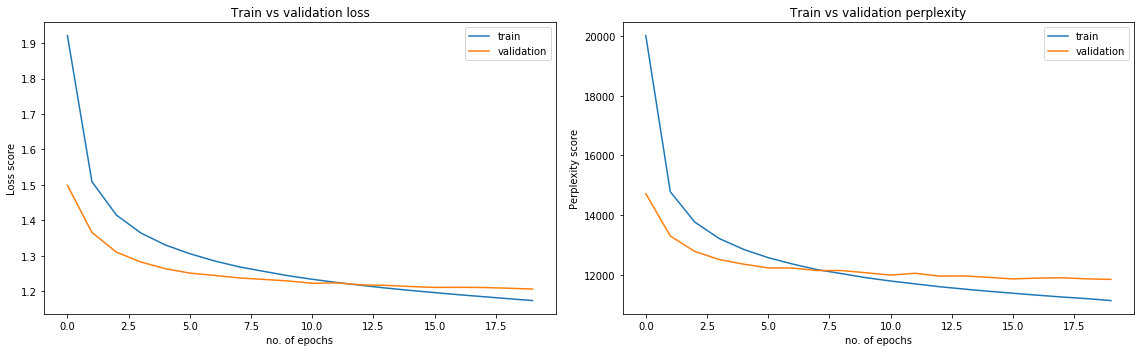

In [17]:
pyplot.figure(figsize=(16,5))


# sp1
pyplot.subplot(121)
pyplot.plot(result.history["loss"])
pyplot.plot(result.history["val_loss"])
pyplot.title('Train vs validation loss')
pyplot.xlabel('no. of epochs')
pyplot.ylabel('Loss score')
pyplot.legend(['train', 'validation'], loc='upper right')

# sp2
pyplot.subplot(122)
pyplot.plot(result.history["perplexity"])
pyplot.plot(result.history["val_perplexity"])
pyplot.title('Train vs validation perplexity')
pyplot.xlabel('no. of epochs')
pyplot.ylabel('Perplexity score')
pyplot.legend(['train', 'validation'], loc='upper right')

pyplot.tight_layout()

pyplot.show()